In [1]:
import twixtools
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from util.twix import *
from util.fft import *
from util.entropy import *
import util.simulator as simulate
from util.coil import * 
from util.cgSolver import * 

In [2]:
data = np.load("../lib/slice1_grappa1.npy")
rawImages = ifft2c(data)
coilmaps = inati_cmap(rawImages) 
dataR = np.copy(data)
R = 2
dataR[::R] = 0
ny, nx, nc = data.shape

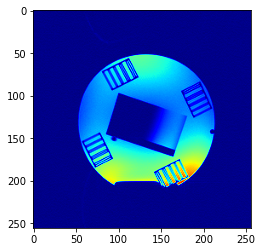

In [3]:
plt.imshow(np.abs(cg_sense(dataR, coilmaps)), cmap = "jet")

In [4]:
x = np.linspace(-0.5, 0.5, nx)
a = 3
b = 3
c = -1
tvecm = np.exp(1j* (a * x**4+b*x+c)) 
data = apply_epi_phase(data, tvecm)

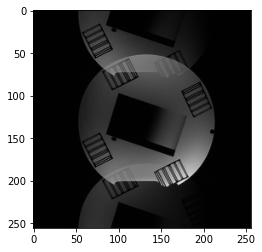

In [5]:
showrsos(ifft2c(data))

In [6]:
import cv2 as cv
def epi_phasecorrection_pecsense(data, coilmaps):
    even = np.zeros(data.shape, dtype = complex)
    odd = np.zeros(data.shape, dtype = complex)
    even[::2] = data[::2]
    odd[1::2] = data[1::2]
    even_recon = cg_sense(even, coilmaps) 
    odd_recon = cg_sense(odd, coilmaps)
    dif = np.angle(even_recon * odd_recon.conj())
    dif = np.float32(dif)
    dif = cv2.bilateralFilter(dif,15,80,80)
    even_coilmaps = np.copy(coilmaps)
    plt.figure()
    plt.imshow(dif)
    plt.show()
    odd_coilmaps = coilmaps *np.repeat(( np.exp(-1j*dif))[:, :, None], repeats=nc, axis=-1)
    recon = cg_sense(np.concatenate((even, odd), axis=-1), np.concatenate((even_coilmaps, odd_coilmaps), axis=-1), 2) 
    return recon

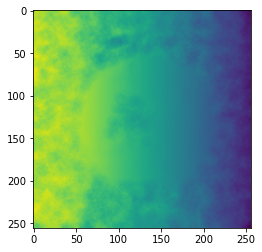

In [7]:
recon = epi_phasecorrection_pecsense(data, coilmaps)

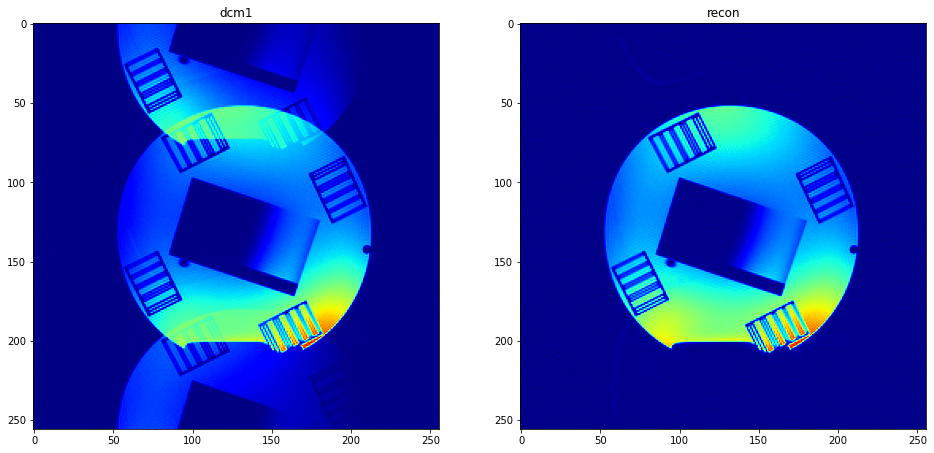

In [8]:
plt.figure(figsize =(16,12))
plt.subplot(1,2,1) 
plt.title("dcm1")
plt.imshow(np.abs((rsos(ifft2c(data)))), cmap ="jet")
plt.subplot(1,2,2)
plt.title("recon")
plt.imshow(np.abs((((recon)))), cmap ="jet")

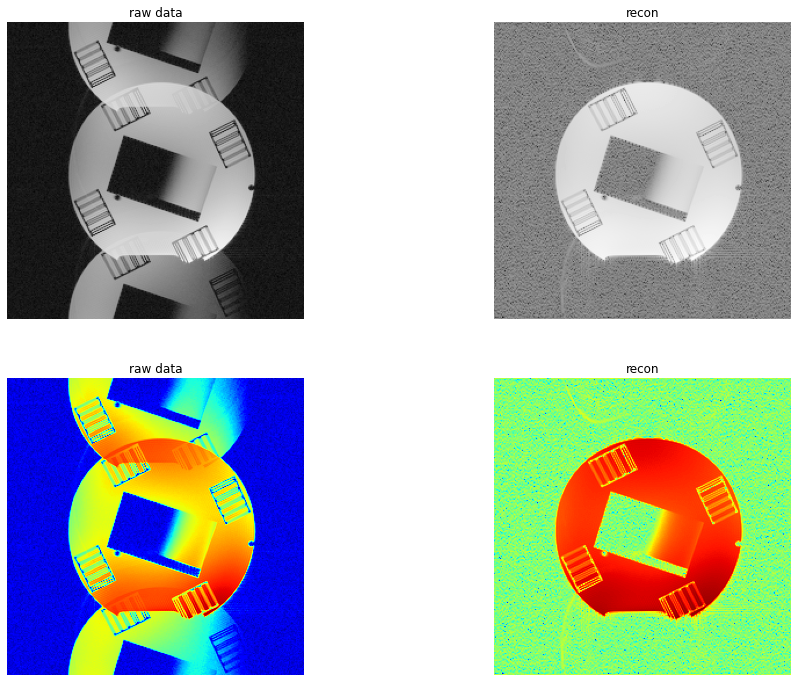

In [10]:
plt.figure(figsize =(16,12))
plt.subplot(2,2,1) 
plt.axis('off')
plt.title("raw data")
plt.imshow(np.abs(np.log(rsos(ifft2c(data)))), cmap ="gray")
plt.subplot(2,2,2)
plt.axis('off')
plt.title("recon")
plt.imshow(np.abs(np.log(((recon)))), cmap ="gray")
plt.subplot(2,2,3)
plt.axis('off')
plt.title("raw data")
plt.imshow(np.abs(np.log(rsos(ifft2c(data)))), cmap ="jet")
plt.subplot(2,2,4)
plt.title("recon")
plt.axis('off')
plt.imshow(np.abs(np.log(((recon)))), cmap ="jet")
plt.savefig("EPI_pecsense.png")